First cut at Full Vehicle Dynamics Model for Performance Trends using equations and values from Form1.vb and FrontSuspension.m. 

Here are the initial assumptions:

Use static values for LF, RF trackwidth
LR & RR trackwidth is the same as LF & RF
Use static panhard angle
Use previous regression equation for LFIC, LFAD, LFFVSA, RFIC, RFAD, RFFVSA, LRAS, RRAS based on Pitch and Roll


Vehicle Suspension Parameters

In [1]:
CGy = 5.1 #Center of Gravity y, in
CGz = 16 #Center of Gravity z, in
LFTW = 32.29 #LF Trackwidth, in
RFTW = 32.25 #RF Trackwidth, in
LRTW = LFTW #LR Trackwidth, in 
RRTW = RFTW #RR Trackwidth, in
WB = 108 #Wheelbase, in
P2CL = 20 #Panhard to Centerline, in
LA2CL = 24 #Lower Arm to Centerline, in
P2LR = LRTW - P2CL #Panhard to LR, in
LRP = 18 #LR Panhard, in
RWR = 13.5 #Rear Wheel Radius, in
PAng = -3.3/57.3 #Panhard angle, converted from deg to rad


Vehicle Weight Parameters

In [2]:
Nose = 50 #Nose Weight Pct, %
Cross = 56 #Cross Weight Pct, %
WLeft = 56 #Left Side Weight Pct, %
WRight = (100-WLeft) #Right Side Weight Pct, %
FBrakeBias = 75 #Front Brake Bias Pct, %
VehWt = 2800 #Vehicle Weight, lbs
USLFWt = 120 #Left Front Unsprung Weight, lbs
USRFWt = 120 #Right Front Unsprung Weight, lbs 
USRWt = 300 #Left Rear Unsprung Weight, lbs
LFStatic = 700 #Left Front Scale Weight, lbs
RFStatic = 700 #Right Front Scale Weight, lbs
LRStatic = 868 #Left Rear Scale Weight, lbs
RRStatic = 528 #Right Rear Scale Weight, lbs
DragCoef = .42 #Vehicle Drag Coef
FrontArea = 21 #Vehicle Frontal Area, ft^2
a = (Nose/100)*WB #Long dist from front axle to CG
b = WB-a #Long dist from rear axle to CG

Suspension Rates

In [3]:
# Tire Spring Rate
KtLF = 1800 #Left Front Tire Spring Rate, lb/in
KtRF = 2500 #Right Front Tire Spring Rate, lb/in
KtLR = 1800 #Left Rear Tire Spring Rate, lb/in
KtRR = 2500 #Right Rear Tire Spring Rate, lb/in

# Wheel Rate
KwLF = 207 #Left Front Wheel Rate, lb/in
KwRF = 185 #Right Front Wheel Rate, lb/in
KwLR = 183 #Left Rear Wheel Rate, lb/in
KwRR = 160 #Right Rear Wheel Rate, lb/in

# Shock Rate
KshLF = 400 #Left Front Shock Rate, lb/in
KshRF = 450 #Right Front Shock Rate, lb/in
KshLR = 400 #Left Rear Shock Rate, lb/in
KshRR = 450 #Right Rear Shock Rate, lb/in

# Roll Bar Rate
Kfarb = 250 #Front Rollbar Rate, lb/in
Krarb = 0 #Rear Rollbar Rate, lb/in

# Suspension Rate
KsLF = KshLF + KwLF + (Kfarb/2)
KsRF = KshRF + KwRF - (Kfarb/2)
KsLR = KshLR + KwLR + (Krarb/2)
KsRR = KshRR + KwRR - (Kfarb/2)

Circle Track Analyzer Outputs
Dive, in
Roll, deg
VehLFWt, lbs
VehRFWt, lbs
VehLRWt, lbs
VehRRWt, lbs
RPM
Torque (missing?)
LongAccel, g's
LatAccel, g's
Downforce, lbs
Speed, mph

Initial test with 5 timesteps to sort code. Should be able to read this file in.

In [4]:
Dive = [0.55, -0.21, -0.33, -0.42, -0.49] 
Roll = [0.42, 1.44, 1.4, 1.31, 1.23]
VehLFWt =[355, 369, 395, 418, 455]
VehRFWt = [986, 920, 851, 798, 764]
VehLRWt = [856, 925, 991, 1038, 1053]
VehRRWt = [906, 833, 751, 686, 634]
RPM = [4316, 4509, 4879, 5251, 5616]
LongAccel = [0, 0.52, 0.53, 0.52, 0.51]
LatAccel = [0.89, 0.88, 0.71, 0.52, 0.37]
Downforce = [317, 310, 246, 172, 115]
Speed = [67, 70, 76, 82, 88]

Perform preliminary calculations that will be used later based on Circle Track Analyzer Output
VertAccel, g's
Drag, lbs
LongForce, lbs
LatForce, lbs

In [5]:
# Vertical Acceleration

VertAccel = [Downforce[i]/VehWt for i in range(len(Downforce))]
#print(VertAccel)

# Convert Speed to ft/s
Speed_fps = [Speed[i]/(5280/3600) for i in range(len(Speed))]
#print(Speed_fps)

# Drag
Drag = [DragCoef*FrontArea*0.00258* Speed_fps[i]**2 for i in range(len(Speed_fps))]
#print(Drag)

# Longitudinal Force
Fx = [(LongAccel[i]*VehWt)+Drag[i] for i in range(len(LongAccel))]
#print(Fx)

# Lateral Force
Fy = [(LatAccel[i]*VehWt) for i in range(len(LatAccel))]
#print(Fy)

Calculate left front and right front instant center, anti dive and front view swing angle using previous regression coefficients. Moving forward, this should be regressed on the fly using dive and roll, or interpolated using dive.

Calculate left rear and right rear anti squat percentage. Moving forward this should be regressed on the fly using the dive and roll, or interpolated using dive.

In [6]:
# Left front instant center
LFIC = [6.3733 + -1.54 * Dive[i] + 0.3317 * Roll[i] + 0.1 * Dive[i]**2 + 0.015 * Roll[i]**2 + -0.08 * Dive[i] * Roll[i]
       for i in range(len(Dive))]
#print(LFIC)

# Left front anti dive
LFAD = [3.7976 + -0.0116 * Dive[i] + 0.1149 * Roll[i] + -0.042 * Dive[i]**2 + -0.0135 * Roll[i]**2 + 0.0613 * Dive[i] * Roll[i]
       for i in range(len(Dive))]
#print(LFAD)

# Left front front view swing angle
LFFVSA = [31.0644 + -1.521 * Dive[i] + 1.1083 * Roll[i] + 0.0802 * Dive[i]**2 + 0.0222 * Roll[i]**2 + -0.1025 * Dive[i] * Roll[i]
       for i in range(len(Dive))]
#print(LFFVSA)

# Right front instant center
RFIC = [6.7767 + -1.625 * Dive[i] + -0.3067 * Roll[i] + 0.115 * Dive[i]**2 + 0.01 * Roll[i]**2 + 0.08 * Dive[i] * Roll[i]
       for i in range(len(Dive))]
#print(RFIC)

# Right front anti dive
RFAD = [-2.4693 + -0.6151 * Dive[i] + -0.2664 * Roll[i] + -0.0652 * Dive[i]**2 + -0.0032 * Roll[i]**2 + -0.0297 * Dive[i] * Roll[i]
       for i in range(len(Dive))]
#print(RFAD)

# Right front front view swing angle
RFFVSA = [34.5054 + -2.2535 * Dive[i] + -1.4583 * Roll[i] + 0.1298 * Dive[i]**2 + 0.0363 * Roll[i]**2 + 0.158 * Dive[i] * Roll[i]
       for i in range(len(Dive))]
#print(RFFVSA)

# Left rear anti squat percentage
LRAS = [28.2053 + -19.5437 * Dive[i] + 12.8093 * Roll[i] + -1.2993 * Dive[i]**2 + 0.0467 * Roll[i]**2 + 0.9687 * Dive[i] * Roll[i]
       for i in range(len(Dive))]
#print(LRAS)

# Right rear anti squat percentage
RRAS = [66.4164 + -16.8635 * Dive[i] + -12.7975 * Roll[i] + -1.2193 * Dive[i]**2 + 0.0487 * Roll[i]**2 + -0.9245 * Dive[i] * Roll[i]
       for i in range(len(Dive))]
#print(RRAS)

Longitudinal Braking, Driving, and Jacking Forces

In [34]:
# Front Longitudinal Ratio

LFLongRatio = (LFTW + CGy)/(LFTW+RFTW)
RFLongRatio = (RFTW - CGy)/(LFTW+RFTW)
#print(LFRatio, RFRatio)

# Rear Longitudinal Ratio

LRLongRatio = (LRTW + CGy)/(LRTW+RRTW)
RRLongRatio = (RRTW - CGy)/(LRTW+RRTW)
#print(LRRatio, RRRatio)

# Seperate longitudinal forces based on braking or acceleration

#Driving
#Drive = [Fx[i] for i in range(len(LongAccel)) if LongAccel[i] > 0 ]
#print(Drive)

#Braking
#Brake = [Fx[i] for i in range(len(LongAccel)) if LongAccel[i] > 0 ]
#print(Drive)

LFFx = []
RFFx = []
LRFx = []
RRFx = []

for i in range(len(LongAccel)):
    if LongAccel[i] >= 0: #Traction
        LFFx.append(0)
        RFFx.append(0)
        LRFx.append(LRLongRatio * Fx[i])
        RRFx.append(RRLongRatio * Fx[i])
    else: #Braking
        LFFx.append(LFLongRatio * Fx[i])
        RFFx.append(RFLongRatio * Fx[i])
        LRFx.append(LRLongRatio * Fx[i])
        RRFx.append(RRLongRatio * Fx[i])
#print(LFFx, RFFx, LRFx, RRFx) 

#LF Longitudinal Jacking Force
LFLongJack = [LFFx[i] *(FBrakeBias/100) * (LFAD[i]/100) for i in range(len(LFFx))]
#print(LFLongJack)

#RF Lonitudinal Jacking Force
RFLongJack = [RFFx[i] *(FBrakeBias/100)*(RFAD[i]/100) for i in range(len(RFFx))]
#print(RFLongJack)

#LR Anti Squat Force
LRLongJack = [LRFx[i] *(LRAS[i]/100) for i in range(len(LRFx))]
#print(LRLongJack)

#RR Anti Squat Force
RRLongJack = [RRFx[i] *(RRAS[i]/100) for i in range(len(RRFx))]
#print(RRLongJack)

Lateral Force and Lateral Jacking Force

In [35]:
#Front Lateral Force 
Fyf = [(a/100)*Fy[i] for i in range(len(Fy))]
#print(Fyf)

#Rear Lateral Force 
Fyr = [Fy[i]-Fyf[i] for i in range(len(Fy))]
#print(Fyr)

#Front Lateral Ratio
LFLatRatio = [VehLFWt[i]/VehWt for i in range(len(VehLFWt))]
RFLatRatio = [VehRFWt[i]/VehWt for i in range(len(VehRFWt))]

#Rear Lateral Ratio
LRLatRatio = [VehLRWt[i]/VehWt for i in range(len(VehLRWt))]
RRLatRatio = [VehRRWt[i]/VehWt for i in range(len(VehRRWt))]
#print(LFLatRatio, RFLatRatio, LRLatRatio, RRLatRatio)

#LF Lateral Force
LFFy = [LFLatRatio[i]*Fyf[i] for i in range(len(LFLatRatio))]

#RF Lateral Force
RFFy = [RFLatRatio[i]*Fyf[i] for i in range(len(RFLatRatio))]
#print(LFFy, RFFy)

#LF Lateral Jacking Force
LFLatJack = [(LFIC[i]/LFFVSA[i])*LFFy[i] for i in range(len(LFIC))]

#RF Lat Force
RFLatJack = [(RFIC[i]/RFFVSA[i])*RFFy[i] for i in range(len(RFIC))]
#print(LFLatJack, RFLatJack)

Rear lateral forces and jacking forces manifest themselves in the sum of the moments around the LR Instant Center and RR Instant Center. The sum of the moments and the rear wheel radius are used to calculate the lateral affect on the LRFz and RRFz forces.

In [36]:
import math as m

#LR Instant Center
P2A = RWR-LRP
LRIC = RWR-P2A- (P2LR*m.tan(PAng))

#RR Instant Center
RRIC = ((LRTW+RRTW)*m.tan(PAng))+LRIC
#print(LRIC, RRIC)

#Sum moments around RR wheel radius to solve for LRFz
LRFz = [((LRLongJack[i]*(LRTW+LA2CL)) - (Fyr[i]*RRIC) + (RRLongJack[i]*(RRTW-LA2CL)))/(LRTW+RRTW)
       for i in range(len(Fyr))]

#Sum moments around LR wheel radius to solve for RRFz
RRFz = [((LRLongJack[i]*(LRTW-LA2CL)) + (Fyr[i]*LRIC) + (RRLongJack[i]*(RRTW+LA2CL)))/(LRTW+RRTW)
       for i in range(len(Fyr))]
#print(LRFz, RRFz)

Solve for aerodynamic forces

In [37]:
# Aerodynamic forces

LFAero = [(Downforce[i]*LFLongRatio)/2 for i in range(len(Downforce))]
RFAero = [(Downforce[i]*RFLongRatio)/2 for i in range(len(Downforce))]
LRAero = [(Downforce[i]*LRLongRatio)/2 for i in range(len(Downforce))]
RRAero = [(Downforce[i]*RRLongRatio)/2 for i in range(len(Downforce))]
#print(LFAero, RFAero, LRAero, RRAero)

Create Spring & Force Matrix for [F] = [k] * [x] size of spring matrix is K(6,6)

In [38]:
import numpy as np

K = np.zeros([7,7])

K[0,0] = -(-KtLF - KsLF - Kfarb)
K[0,1] = -Kfarb
K[0,4] = -KsLF
K[0,5] = -a*KsLF
K[0,6] = -(LFTW * KsLF + (LFTW +RFTW)*Kfarb)

K[1,0] = -(Kfarb)
K[1,1] = -(-KtRF - KsRF - Kfarb)
K[1,4] = -KsRF
K[1,5] = -a*KsRF
K[1,6] = -(RFTW * KsRF + (LFTW +RFTW)*Kfarb)

K[2,2] = -(-KtLR - KsLR - KtRR - KsRR)
K[2,3] = -(-LRTW*(KtLR+KsLR) + (RRTW*(KtRR+KsRR)))
K[2,4] = -(KsLR+KsRR)
K[2,5] = -(-b*KsLR-b*KsRR)
K[2,6] = -(LRTW * KsLR - RRTW * KsRR)

K[3,2] = -(-LRTW*KtLR-LRTW*KsLR - (-RRTW *KtRR) - (-RRTW*KsRR))
K[3,3] = -(-LRTW*LRTW*(KtLR+KsLR) - (RRTW*(RRTW)*(KtRR+KsRR)) - ((LRTW+RRTW)*(LRTW+RRTW)*Krarb))
K[3,4] = -(LRTW*KsLR + (-RRTW) * KsRR)
K[3,5] = -(-b*LRTW * KsLR - b * (-RRTW) * KsRR)
K[3,6] = -(LRTW*LRTW*KsLR + RRTW*(RRTW)*KsRR + ((LRTW+RRTW)*(LRTW+RRTW)*Krarb))

K[4,0] = -(KsLF)
K[4,1] = -(KsRF)
K[4,2] = -(KsLR + KsRR)
K[4,3] = -(LRTW * KsLR - RRTW * KsRR)
K[4,4] = -(-KsLF - KsRF - KsLR - KsRR)
K[4,5] = -(-a*(KsLF+KsRF) + b *(KsLR +KsRR))
K[4,6] = -(-LFTW*(KsLF) + RFTW*(KsRF) - LRTW*(KsLR) + RRTW *(KsRR))

K[5,0] = -(a*KsLF)
K[5,1] = -(a*KsRF)
K[5,2] = -(-b*(KsLR + KsRR))
K[5,3] = -((-b*LRTW) * KsLR + (b*RRTW) * KsRR)
K[5,4] = -(-a*(KsLF + KsRF) + b*(KsLR - KsRR))
K[5,5] = -((-a*a)*(KsLF+KsRF) + (-b*b) *(KsLR +KsRR))
K[5,6] = -((-a*LFTW*(KsLF)) + (a*RFTW*(KsRF)) + (b*LRTW*(KsLR)) + (-b*RRTW *(KsRR)))

K[6,0] = -(LFTW * (KsLF) + (LFTW+RFTW)*Kfarb)
K[6,1] = -(-RFTW * (KsRF) - (LFTW+RFTW)*Kfarb)
K[6,2] = -(LRTW*KsLR - RRTW * KsRR)
K[6,3] = -((LRTW*LRTW) * KsLR + (RRTW*RRTW) * KsRR + (LRTW+RRTW)*Krarb)
K[6,4] = -(-LFTW*(KsLF) + RFTW *(KsRF) - LRTW*(KsLR) + RRTW * (KsRR))
K[6,5] = -((-a*LFTW*(KsLF)) +(a*RFTW*(KsRF)) + (b*LRTW*(KsLR)) + ((-b*RRTW)*(KsRR)))
K[6,6] = -(((-LFTW*LFTW)*(KsLF)) - ((RFTW*RFTW)*(KsRF)) - ((LRTW*LRTW)*(KsLR)) - ((RRTW*RRTW)*(KsRR)) - ((LFTW+RFTW)*(LFTW+RFTW)*Kfarb) - ((LRTW+RRTW)*(LRTW+RRTW)*Krarb))
#print(K)


f = [0] *7
f[0] = [(VertAccel[i] * USLFWt + (LFLatJack[i] + LFLongJack[i])) for i in range(len(VertAccel))]
f[1] = [(VertAccel[i] * USRFWt + (RFLatJack[i] + RFLongJack[i])) for i in range(len(VertAccel))]
f[2] = [(VertAccel[i] * USRWt + (LRFz[i] + RRFz[i])) for i in range(len(VertAccel))]
f[3] = [(LatAccel[i] * USRWt *13.5) for i in range(len(VertAccel))]
f[4] = [(VertAccel[i] * VehWt - (LFLatJack[i] + LFLongJack[i]+ RFLatJack[i] + RFLongJack[i] + LRFz[i] +RRFz[i]) + (LFAero[i]+RFAero[i]+LRAero[i]+RRAero[i])) for i in range(len(VertAccel))]
f[5] = [(LongAccel[i] * VehWt *CGz + (LRAero[i] +RRAero[i]) * b-(LFAero[i]+RFAero[i]) * a + (LRFz[i]+RRFz[i]) *b - (LFLatJack[i]+LFLongJack[i] + RFLatJack[i] +RFLongJack[i])*a) for i in range(len(LongAccel))]
f[6] = [(LatAccel[i] * VehWt * CGz + (RFAero[i] + RRAero[i]) * ((LFTW+RFTW) / 2) - (LFAero[i] + LRAero[i]) * ((LFTW+RFTW)  / 2) + (RFLatJack[i] + RFLongJack[i] + RRFz[i]) * ((LFTW+RFTW) / 2) - (LFLatJack[i] + LFLongJack[i] + LRFz[i]) * ((LFTW+RFTW) / 2)) for i in range(len(LatAccel))]
#print(f)

The next cell below isn't used. Trying to validate the math on the inverse K matrix.

In [12]:
def ComputeCoefficients(K,F,N,M,M1,I,J):
    N = 7
    for M in range(7):
        M1 = M+1
        for I in range(M, 6):
            if K[I, M] != 0:
                for J in range(M1,6):
                    K[I,J] /= K[I,M]
                F[I] /= K[I,M]
        for I in range(M1,6):
            if K[I,M] != 0:
                for J in range(M1,6):
                    K[I,J] -= K[M,J]
                F[I] -=F[M]
    for I in range(N-2, 0, -1):
        for J in range(N-1,I+1, -1):
            F[I] -= K[I,J] * F[J]
    return (N,M,M1,I,J,F)

Loop through each F with K matrix. X = inv(K)*F 

In [39]:


F = [0] *7
for i in range(len(VertAccel)):
    F[0] = f[0][i]
    F[1] = f[1][i]
    F[2] = f[2][i]
    F[3] = f[3][i]
    F[4] = f[4][i]
    F[5] = f[5][i]
    F[6] = f[6][i]
    
    kinv = np.linalg.inv(K)
    #print(kinv)
    X = -kinv*F
    #print(X)
    
    #Front Displacement
    LFDisp = [X[0][i] for i in range(len(X))]
    RFDisp = [X[1][i] for i in range(len(X))]
    
    # Rear Dispalcement 
    LRDisp = [X[2][i] - (LRTW*X[3][i]) for i in range(len(X))]
    RRDisp = [X[2][i] + (LRTW*X[3][i]) for i in range(len(X))]
    
    
    # Wheel loads
    LFFz = [LFStatic + (KsLF * X[0][i]) for i in range(len(X))]
    RFFz = [RFStatic + (KsRF * X[1][i]) for i in range(len(X))]
    LRFz = [LRStatic + (KsLR * LRDisp[i]) for i in range(len(X))]
    RRFz = [LRStatic + (KsRR * RRDisp[i]) for i in range(len(X))]
    
    load = {"LFFz":LFFz,
            "RFFz":RFFz,
            "LRFz":LRFz,
            "RRFz":RRFz}
disp = {"LFDisp":LFDisp,
            "RFDisp":RFDisp,
            "LRDisp":LRDisp,
            "RRDisp":RRDisp}    


Write out text file

In [40]:
import csv

with open("LoadDisp.csv","w", newline="") as new:
    
    writer = csv.writer(new)
    writer.writerows(load.items())
    writer.writerows(disp.items())

Create some plots of displacement and wheel load

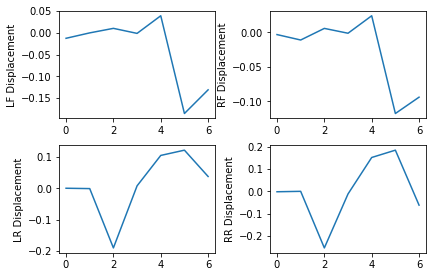

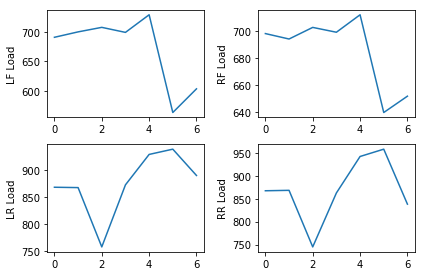

In [41]:
import matplotlib.pyplot as plt

# LF Displacement
plt.figure(1)
plt.subplot(221)
plt.plot(LFDisp)
plt.ylabel('LF Displacement')


# RF Displacement
plt.subplot(222)
plt.plot(RFDisp)
plt.ylabel('RF Displacement')


# LR Displacement
plt.subplot(223)
plt.plot(LRDisp)
plt.ylabel('LR Displacement')


# RR Displacement
plt.subplot(224)
plt.plot(RRDisp)
plt.ylabel('RR Displacement')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

# LF Load
plt.figure(2)
plt.subplot(221)
plt.plot(LFFz)
plt.ylabel('LF Load')


# RF Load
plt.subplot(222)
plt.plot(RFFz)
plt.ylabel('RF Load')


# LR Load
plt.subplot(223)
plt.plot(LRFz)
plt.ylabel('LR Load')


# RR Load
plt.subplot(224)
plt.plot(RRFz)
plt.ylabel('RR Load')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()